In [1]:
# import statements
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# define global variables for use in callback functions
global previous_lines

In [3]:
global past_curverad
past_curverad = 0

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


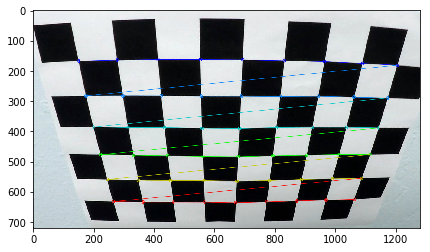

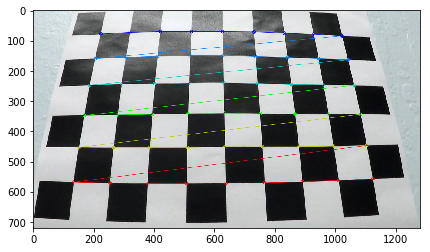

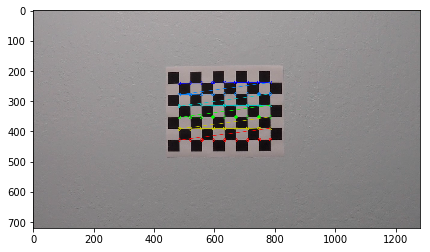

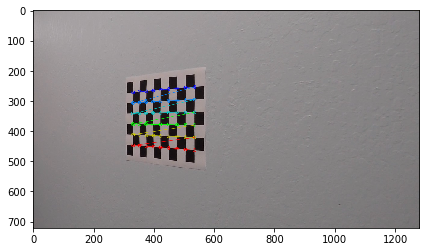

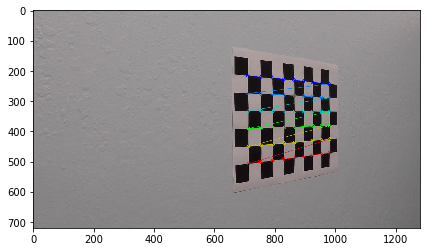

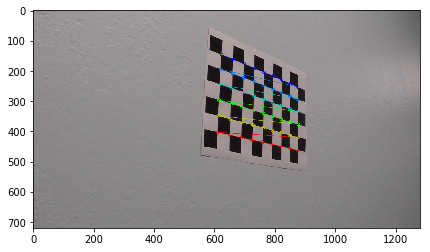

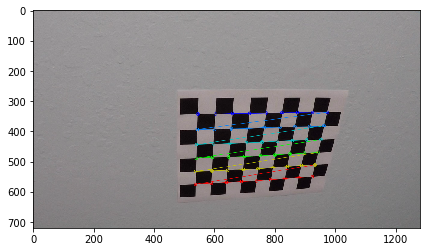

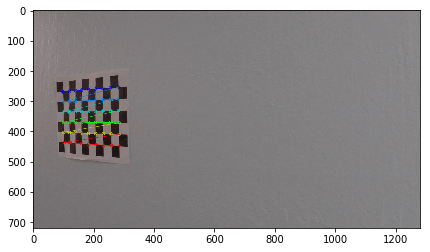

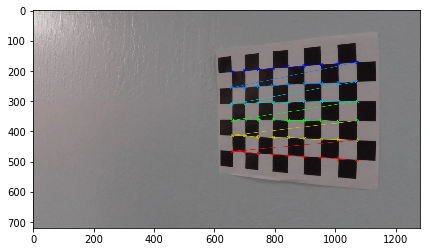

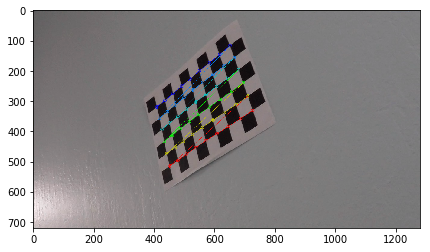

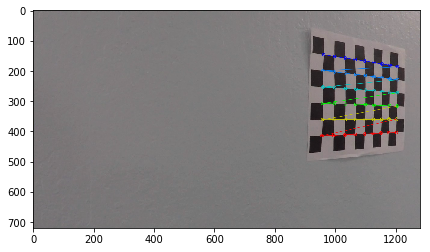

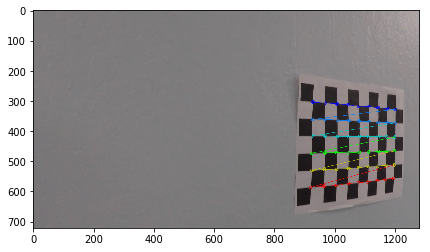

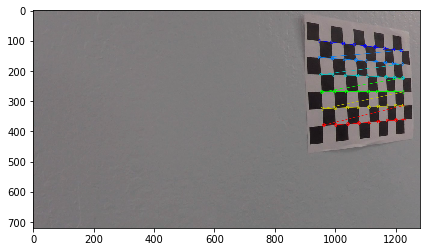

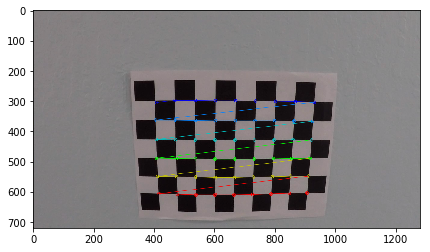

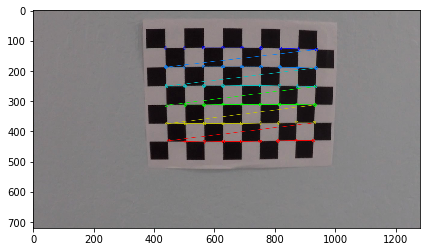

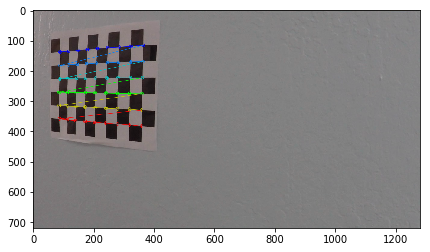

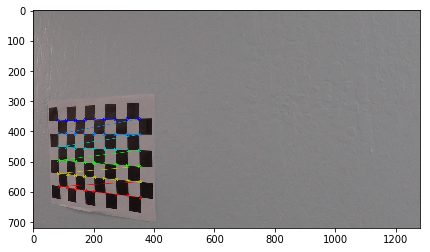

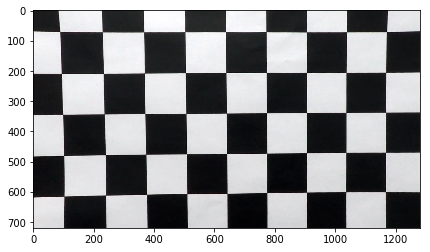

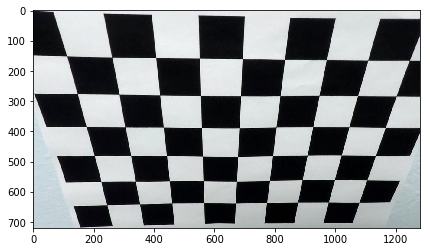

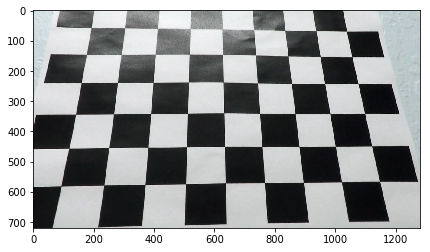

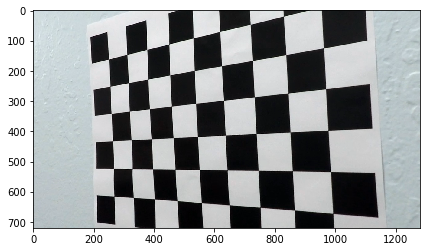

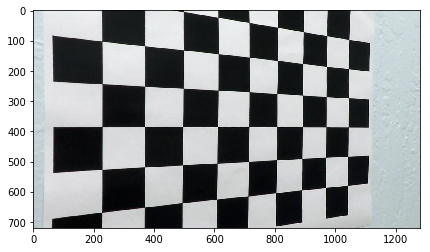

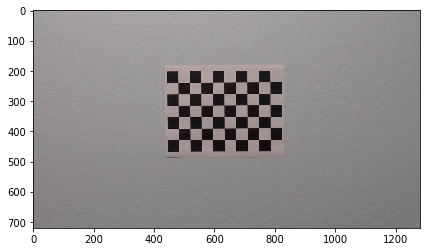

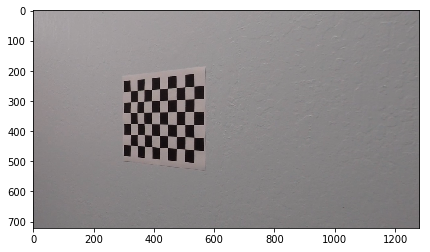

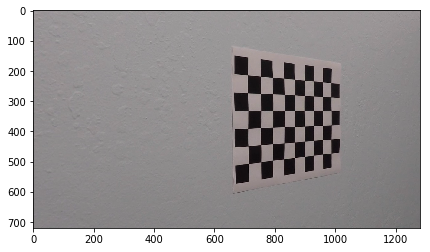

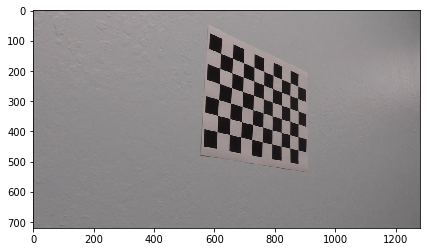

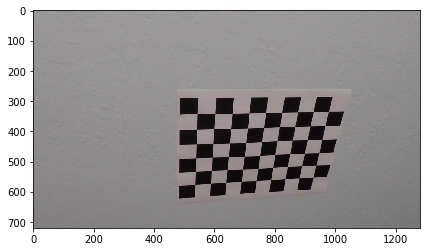

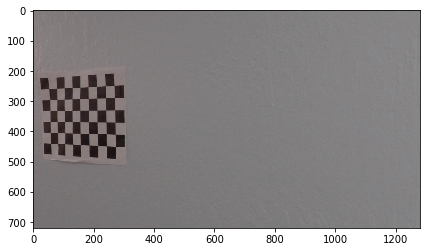

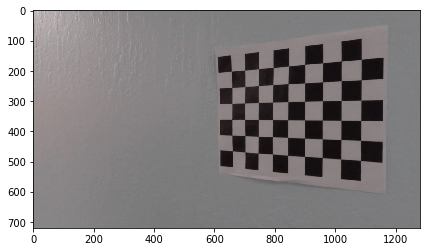

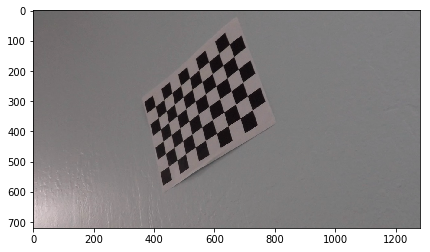

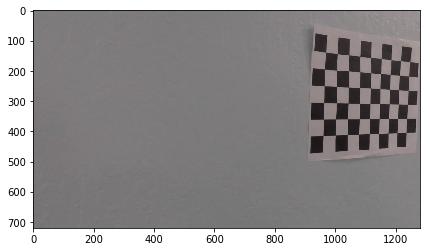

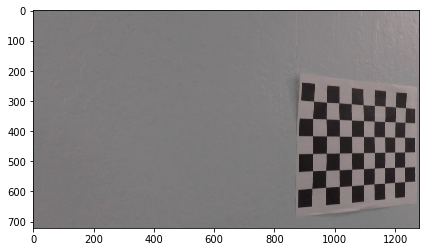

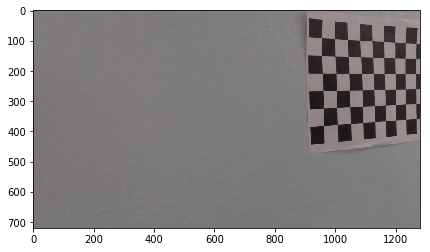

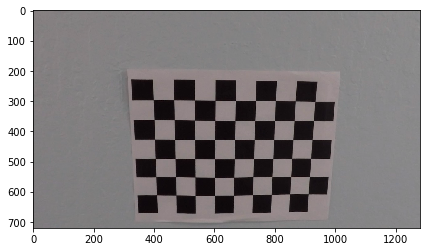

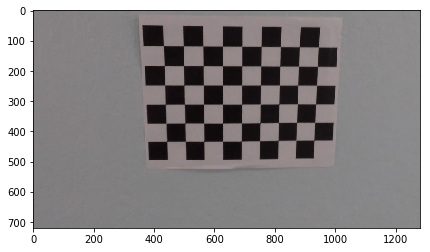

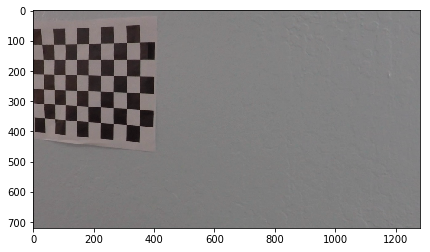

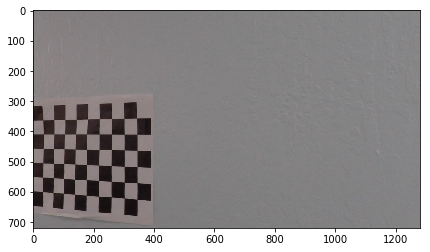

In [4]:
## Calibration

# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
objpoints = []
imgpoints = []
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
for i in range(1, 21):
    fname = 'camera_cal/calibration' + str(i) + '.jpg'
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure(figsize=(8,4))
        plt.imshow(img)
        cv2.imwrite('camera_cal/calibration' + str(i) + '_dots' + '.jpg', img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort images for trial

for i in range(1, 21):
    fname = 'camera_cal/calibration' + str(i) + '.jpg'
    img = cv2.imread(fname)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/calibration' + str(i) + '_cal' + '.jpg', undist)
    plt.figure(figsize=(8,4))
    plt.imshow(undist)

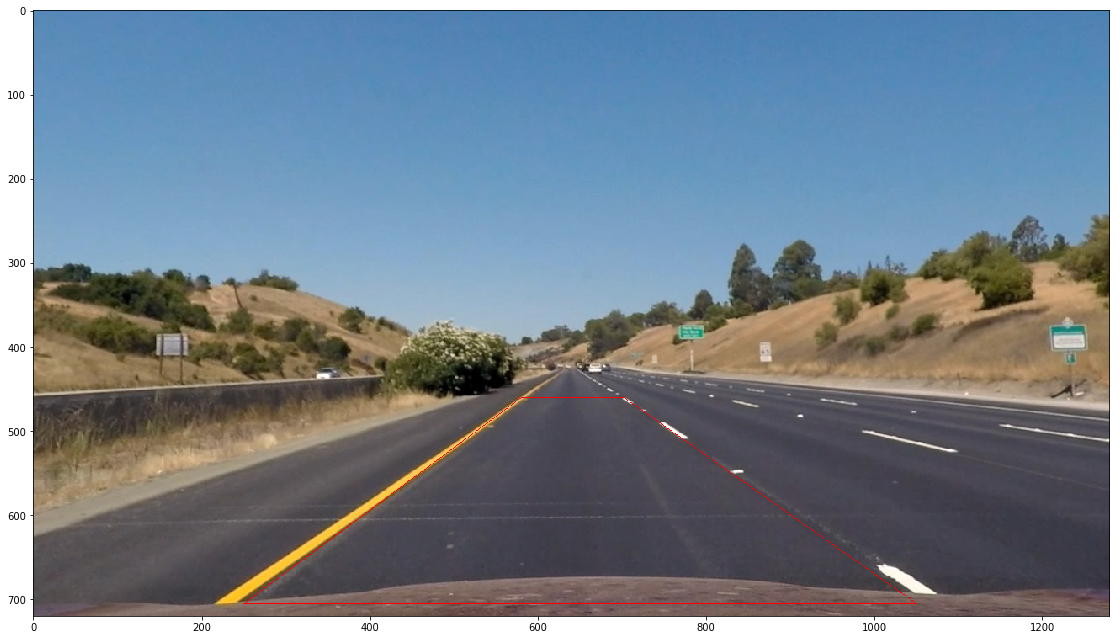

In [5]:
## Bird's eye view (perspective transform)

# Undistort image
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, mtx, dist, None, mtx)
bird_eye = np.copy(undist)

# Undistort function for later use
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx) 
    return undist

# Find rectangle
pts = np.int32([[702, 460],[580, 460],[250, 705],[1050, 705]])

#pts = np.int32([[262, 670],[594, 450],[686 ,450],[1043, 670]])
pts = pts.reshape((-1,1,2))
cv2.polylines(undist,[pts],True,(255,0,0))

f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)

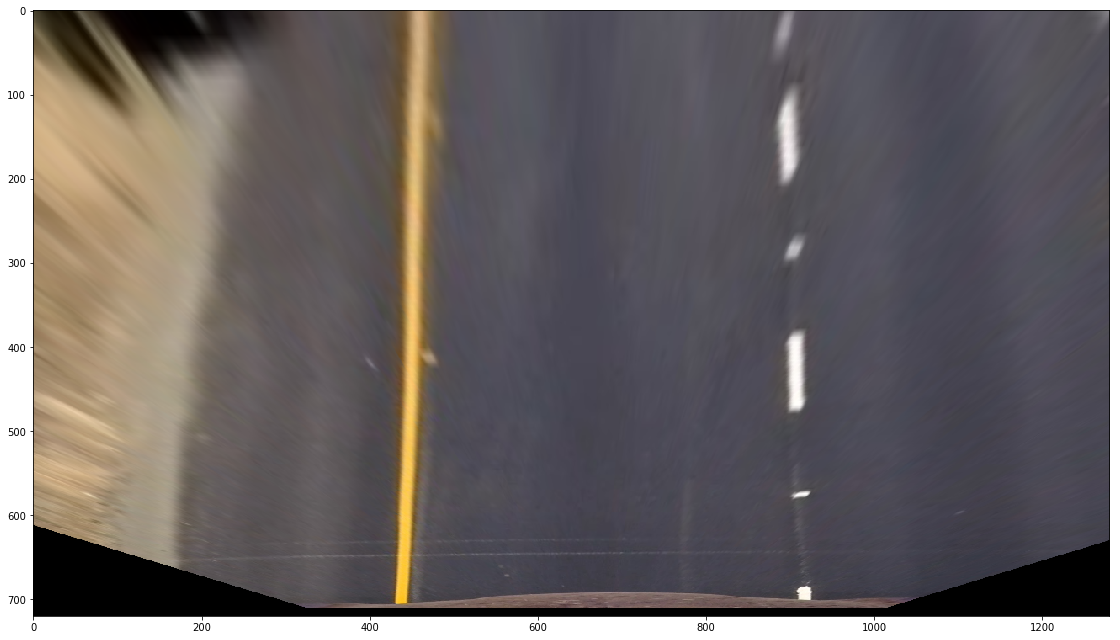

In [6]:
# Perspective transform functions
pts = np.float32(pts)
dst = np.float32([[900, 100],[450, 100],[450, 705],[900, 705]])
def perspective(img):
    M = cv2.getPerspectiveTransform(pts, dst)
    if len(img.shape) == 3:
        shape = img.shape[::-1][1:]
    else:
        shape = img.shape[::-1]
    warped = cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)
    return warped

def inv_perspective(img):
    M = cv2.getPerspectiveTransform(dst, pts)
    if len(img.shape) == 3:
        shape = img.shape[::-1][1:]
    else:
        shape = img.shape[::-1]
    warped = cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)
    return warped

warped = perspective(bird_eye)
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()   
ax1.imshow(warped)

In [7]:
# region of interest (mask) functions
vertices = np.array([[[130, 500], [439, 330], [529, 330], [900, 500]]])

def region_of_interest(img):
    #change vertex locations based on shape of image
    new_vertices = calc_vertices(img, vertices)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, new_vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_vertices(img, vertices):
    # adjusting region of interest for image size
    y = img.shape[0]
    x = img.shape[1]
    new_vertices = np.copy(vertices)
    new_vertices[:,:,0] = (new_vertices[:,:,0]*x/960.0).astype(int)
    new_vertices[:,:,1] = (new_vertices[:,:,1]*y/540.0).astype(int)
    return new_vertices

In [8]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def slh_threshold(SL, thresh):
    # apply threshold to S, L and H images
    binary = np.zeros_like(SL)
    binary[(SL > thresh[0]) & (SL <= thresh[1])] = 1
    return binary


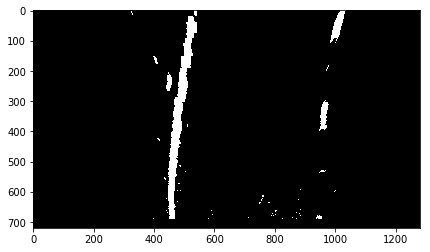

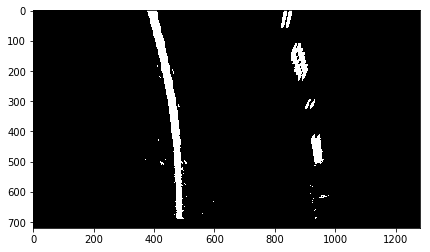

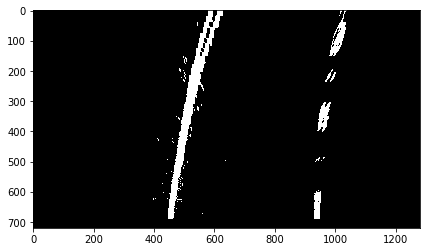

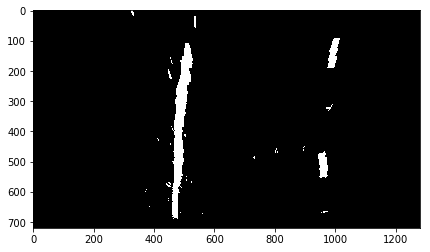

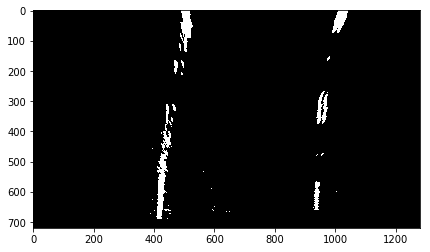

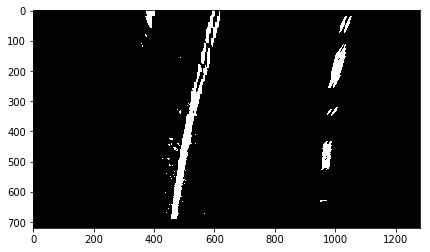

In [9]:
s_thresh = (130, 255)
l_thresh = (50, 255)
h_thresh = (19, 25)
sobel_thresh = (30, 170)
# Load and process test images
test_images = []
for i in range (1, 7):
    name = "test_images/test" + str(i) + ".jpg"
    image = cv2.imread(name)
    #im2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = undistort(image)
    HLS = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    hue = slh_threshold(HLS[:,:,0], h_thresh)
    sat = slh_threshold(HLS[:,:,2], s_thresh)
    light = slh_threshold(HLS[:,:,1], l_thresh)
    sobel = abs_sobel_thresh(undist, thresh = sobel_thresh)
    sat[hue == 1] = 1
    sat[light == 0] = 0
    sat[sobel == 1] = 1
    mask = region_of_interest(sat)
    persp = perspective(mask)
    plt.figure(figsize=(8,4))
    plt.imshow(persp, interpolation='nearest', cmap = 'gray')
    test_images.append(persp)

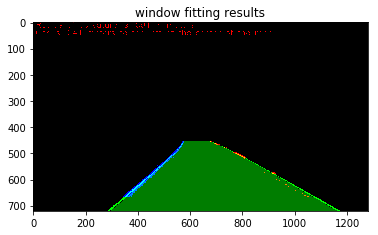

In [10]:
## Sliding window search
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = test_images[1]
# window settings
window_width = 50 
window_height = 89 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    # define window area in image
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    # combine two 3-channel images
    return cv2.addWeighted(initial_img, α, img, β, λ)

def find_window_centroids(image, window_width, window_height, margin):
    # find locations of windows for the sliding window search
    window_centroids = []
     # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    strike_l = 0
    strike_r = 0
    continue_l = 1
    continue_r = 1
    counter = 0
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        counter += 1
        if continue_l == 1:
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            if np.amax(conv_signal[l_min_index:l_max_index]) <= 30:
                strike_l += 1
                if strike_l%2 == 0:
                    continue_l = 0
                    window_centroids = np.array(window_centroids)
                    window_centroids[-3:] [:, 1] = 0
                    window_centroids = list(window_centroids)
                    l_center = 0
            else:
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                
        else:
            l_center = 0
        # Find the best right centroid by using past right center as a reference
        if continue_r == 1:
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            if np.amax(conv_signal[r_min_index:r_max_index]) <= 30:
                strike_r += 1
                if strike_r%2 == 0:
                    continue_r = 0
                    #print (counter, "counter")
                    window_centroids = np.array(window_centroids)
                    window_centroids[-2:] [:, 1] = 0
                    window_centroids = list(window_centroids)
                    r_center = 0
            else:
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            
        else: 
            r_center = 0
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids



def sliding_window_search(warped, window_width = 50, window_height = 90):
    # find lanes 
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            # Add graphic points from window mask here to total pixels found
            if window_centroids[level][0] != 0:
                l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level) 
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            if window_centroids[level][1] != 0:
                r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        zero_channel = np.zeros_like(warped) # create a zero color channel
        # create channel 1 & 2. Populate with points from left and right detected lane lines 
        # and apply inverse perspective transform
        channel1 = warped.copy()
        channel1[l_points == 0] = 0
        unwarp_left = inv_perspective(channel1)*255
        left_img = np.dstack((np.zeros_like(zero_channel), np.zeros_like(zero_channel), unwarp_left))
        channel2 = warped.copy()
        channel2[r_points == 0] = 0
        unwarp_right = inv_perspective(channel2)*255
        right_img = np.dstack((unwarp_right, np.zeros_like(zero_channel), np.zeros_like(zero_channel)))
        # Find coordinates of all lane pixels
        y_l, x_l = np.nonzero(channel1)
        y_r, x_r = np.nonzero(channel2)
        # proceed if number of pixels is not small and the differences between highest and lowest y is not small
        if (x_l.shape >= (200,)) and (x_r.shape >= (200,)) and \
            (np.amax(y_l) - np.amin(y_l) > 250) and (np.amax(y_r) - np.amin(y_r) > 250):
            # fit lines (get parameters)
            left_fit = np.polyfit(y_l, x_l, 2)
            right_fit = np.polyfit(y_r, x_r, 2)
            #  compute x for each y using fit parameters
            left_y = np.arange(channel1.shape[0])
            left_x = (left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]).astype(int)
            right_y = np.arange(channel2.shape[0])
            right_x = (right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]).astype(int)
            # combine points
            left_points1 = np.dstack((left_x, left_y))[0]
            right_points1 = np.dstack((right_x, right_y))[0]
            left_points = left_points1.reshape((-1,1,2))
            right_points = right_points1.reshape((-1,1,2))
            # draw lane on zero channel
            right_points_reversed = np.flipud(right_points1)
            poly = np.array(np.concatenate((left_points1, right_points_reversed)))
            cv2.fillConvexPoly(zero_channel, poly, (125, 0, 0))
            # draw lines on zero channel
            cv2.polylines(zero_channel, [left_points], False, (255, 0, 0), 5)
            cv2.polylines(zero_channel, [right_points], False, (255, 0, 0), 5)
            # stack images containing left and right line pixels and fitted lines
            unwarp = np.dstack((np.zeros_like(zero_channel), inv_perspective(zero_channel), np.zeros_like(zero_channel)))
            output = np.zeros_like(unwarp)
            output[(unwarp == 125)] = 125
            output[(unwarp == 255) | (left_img == 255) | (right_img == 255)] = 255 
            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(y_l*ym_per_pix, x_l*xm_per_pix, 2)
            right_fit_cr = np.polyfit(y_r*ym_per_pix, x_r*xm_per_pix, 2)
            # Calculate the new radii of curvature
            y_eval = output.shape[0]
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            curverad = (left_curverad+right_curverad)/2
            text1 = "Radius of curvature is: " + str(int(curverad)) + " in meters"
            # calculate car offset
            center = np.round((output.shape[1]/2 - (right_x[-1] + left_x[-1]) / 2)*xm_per_pix, 2)
            if center > 0:
                text2 = "Car is "+str(np.abs(center))+" meters to the right of the center of the road"
            else:
                text2 = "Car is "+str(np.abs(center))+" meters to the left of the center of the road"
            # write on image
            cv2.putText(output, text1, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
            cv2.putText(output, text2, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
            global previous_lines
            previous_lines = output
        else:
            # if frame not accepted, use previous frame
            output = previous_lines
    return output
output = sliding_window_search(warped)
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [11]:
def process_image(img):
    undist = undistort(img)
    HLS = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    hue = slh_threshold(HLS[:,:,0], h_thresh)
    sat = slh_threshold(HLS[:,:,2], s_thresh)
    light = slh_threshold(HLS[:,:,1], l_thresh)
    sobel = abs_sobel_thresh(undist, thresh = sobel_thresh)
    sat[hue == 1] = 1
    sat[light == 0] = 0
    sat[sobel == 1] = 1
    mask = region_of_interest(sat)
    persp = perspective(mask)
    lines = sliding_window_search(persp)
    lines_img = weighted_img(lines, undist)
    return lines_img

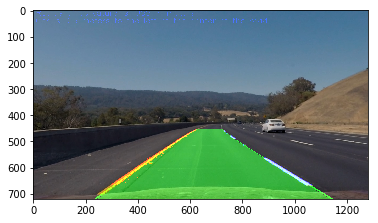

In [12]:
img = cv2.imread("test_images/test3.jpg")
out = process_image(img)
out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
plt.imshow(out)


In [13]:
# Import everything needed to edit/save/watch video clips
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
project_video_out = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(project_video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 17s, sys: 4.67 s, total: 4min 21s
Wall time: 3min 3s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out))